# Quantum Zassenhausen Algorithm

Reformulation of the Zassenhausen algorithm to work with the `QuantumCircuits.jl` package by giving it a physical interpretation.

Given two subgroups of Pauli string group on N bits, $G_1 \subset P_2^N$ and $G_2 \subset P_2^N$, we would like to compute the sizes of their sum and intersection, $\langle G_1, G_2 \rangle$ and $G_1 \cap G_2$.

We need two maps:

1. $f: P_2^N \rightarrow P_2^{4N}, \quad f(g) = g \otimes g \otimes g \otimes g,$ where $\otimes$ is the Pauli string concatanation.

2. $h: P_2^N \rightarrow P_2^{4N}, \quad f(g) = g \otimes g \otimes e \otimes e,$ where $e$ is the identity of $P_2^N$.

Via which we now can define the Zassenhausen stabiliser state from these subgroups as: $$S_Z = \langle f(G_1), h(G_2) \rangle.$$

Whose entanglement measures encode what we want:

1. $ S_{vN} (S_Z, 1:4N) = 4N - \text{dim} \langle G_1, G_2 \rangle - \text{dim} G_1 \cap G_2 $

2. $ S_{vN} (S_Z, 2N+1:4N) = 2N - \text{dim} G_1 \cap G_2 $

# Zassenhausen Correlator

The anyonic two point function definition based around Pauli subgroups overlap.

The state is defined via the stabiliser group $|\Psi\rangle \equiv S_\Psi$.

The corrleator is associayed

# Testing the full Anyon Correlator Algorithm

Taking all the subrutines we have wrote we test them here on TC mmt induced transitions.

In [1]:
using Base.Filesystem  # for creaating directories etc
using Random, Distributions  # random numbers
using HDF5  # hdf5 files
using QuantumClifford  # this is the stabilizer simulation package
using Plots # for plotting
using Formatting # string formatting
using LinearAlgebra # some useful matrices etc.
dep_path = "../AdditionalStructure/Julia/"
include("$(dep_path)NewTypes.jl")
include("$(dep_path)BitStringOps.jl")
include("$(dep_path)Measurements.jl")
include("$(dep_path)MICModels.jl")
include("$(dep_path)ModelRuns.jl")
include("$(dep_path)HelperTools.jl")
include("$(dep_path)Iterators.jl");

┌ Warning: backend `GR` is not installed.
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/backends.jl:43


In [2]:
function taxi_metrix_torus(x1, y1, x2, y2, Lx, Ly)
    dx = abs(x1 - x2)
    dy = abs(y1 - y2)
    dx = min(dx, Lx - dx)
    dy = min(dy, Ly - dy)
    return dx + dy
end

function taxi_metrix_torus(x1::Tuple{Int, Int}, x2::Tuple{Int, Int}, Lx, Ly)
    return taxi_metrix_torus(x1[1], x1[2], x2[1], x2[2], Lx, Ly)
end

function euclidean_metrix_torus(x1, y1, x2, y2, Lx, Ly)
    dx = abs(x1 - x2)
    dy = abs(y1 - y2)
    dx = min(dx, Lx - dx)
    dy = min(dy, Ly - dy)
    return sqrt(dx^2 + dy^2)
end

function euclidean_metrix_torus(x1::Tuple{Int, Int}, x2::Tuple{Int, Int}, Lx, Ly)
    return euclidean_metrix_torus(x1[1], x1[2], x2[1], x2[2], Lx, Ly)
end

euclidean_metrix_torus (generic function with 2 methods)

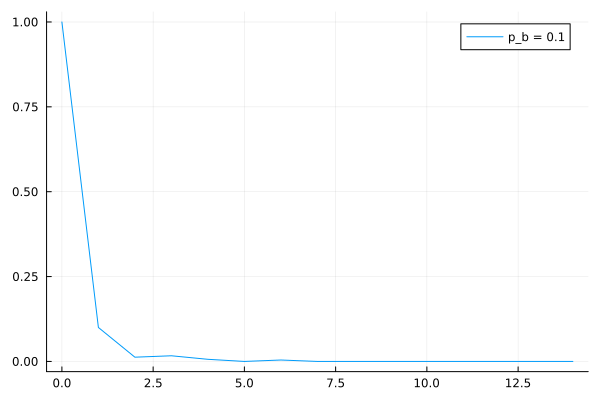

In [3]:
L = 15
d = 3

system = Init_EdgeSquareLattice_KitaevDoNuT(L, d)
t_mmt = Array{Int}(20:20:200).+50
n_t = length(t_mmt)
t_old = 0
e_deformator = get_e_deformator(system)
f_deformator = get_f_deformator(system)

all_r = []
for i = 1:L
    for j = 1:L
        x_i = i - 1
        y_i = j - 1
        push!(all_r, taxi_metrix_torus((0, 0), (x_i, y_i), L, L))
    end
end

r_max, _ = findmax(all_r)
plot_x = [0:r_max]

norm_y = zeros(Float64, r_max + 1)
for i = 1:L
    for j = 1:L
        x_i = i - 1
        y_i = j - 1
        norm_y[taxi_metrix_torus((0, 0), (x_i, y_i), L, L) + 1] += 1
    end
end

# Setup Done

scatter()

# Iteration 1

p_f = 0.0
p_b = 0.1
p_tc = 1 - p_f - p_b
stab_distro = Categorical([p_tc/2, p_tc/2, p_b, 0, p_f])
state = toric_code_GS(system)

corr_function = zeros(Float64, L, L)

for t_index in 1:n_t
    t_evol = t_mmt[t_index] - t_old
    t_old = t_mmt[t_index]
    state = iterate_measurements_only_fast!(state, system, () -> toric_code(system, stab_distro), t_evol)
    corr_function += general_zassenhausen_correlator(state, system, get_e_reprentative, e_deformator)
end

plot_y = zeros(Float64, r_max + 1)
for i = 1:L
    for j = 1:L
        x_i = i - 1
        y_i = j - 1
        plot_y[taxi_metrix_torus((0, 0), (x_i, y_i), L, L) + 1] += corr_function[i, j]/n_t
    end
end

plot!(plot_x, plot_y ./ norm_y, label = "p_b = $(p_b)")